# Generate mixture data

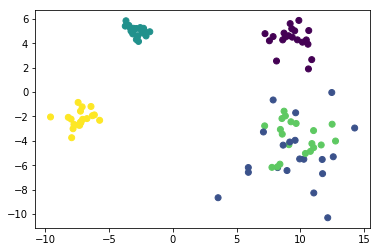

In [258]:
%matplotlib inline
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt
import numpy as np

# Fix random seed
np.random.seed(24)

# Number of samples
N_SAMPLES = 100
# Number of mixtures
K = 5

X, y = make_blobs(n_samples=N_SAMPLES, 
                  cluster_std=[1.0, 2.5, 0.5, 1.5, .8], 
                  centers=K)

X = X.astype('float32')
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.viridis);

# Kmeans and deterministic GMM

Text(0.5,1,u'kmean with 5 clusters')

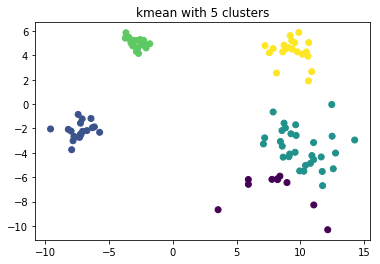

In [259]:
from sklearn.cluster import KMeans

y1 = KMeans(n_clusters=K, 
            # n_init
            # Number of time the k-means algorithm will be run with different centroid seeds. 
            # The final results will be the best output of
            n_init=50).fit_predict(X)

plt.scatter(X[:, 0], X[:, 1], c=y1, cmap=plt.cm.viridis);
plt.title("kmean with {} clusters".format(K))

# Using Stochastic Approximation

In [37]:
import theano
import scipy.stats as stats
floatX = "float32"
from theano import shared

import theano.tensor as tt
import pymc3 as pm
from pymc3.math import logsumexp

# A linalg solver from theano.tensor
solver = tt.slinalg.Solve(A_structure="lower_triangular", lower=True)

def stick_breaking(beta):
    portion_remaining = tt.concatenate([[1], tt.extra_ops.cumprod(1 - beta)[:-1]])
    return beta * portion_remaining

# Log likelihood of Gaussian mixture distribution
def GMM_logp(weight, mus, chol):
    def logp_(value):
        Ncomp = len(chol)
        logps = []
        for i in range(Ncomp):
            mu = mus[:, i]
            chol_cov = chol[i]
            k = chol_cov.shape[0]

            delta = value.reshape((-1, k)) - mu
            delta_trans = solver(chol_cov, delta.T)

            result = k * tt.log(2 * np.pi)
            result += 2.0 * tt.sum(tt.log(tt.nlinalg.diag(chol_cov)))
            result += (delta_trans ** 2).sum(axis=0).T
            logps.append(tt.log(weight[i]) + -0.5*result)
        return logsumexp(tt.stacklists(logps), axis=0)
    return logp_

# MAX_K << K 
MAX_K = 5

# Define the model
with pm.Model() as model:
    
    # The alpha parameter for the Dirichlet distribution
    alpha = pm.Gamma('alpha', alpha=1., beta=1., transform=None)
    # The beta parameter which samples from the Dirichlet distribution
    beta = pm.Beta('beta', 1., alpha, shape=MAX_K, transform=None)
    # A deterministic variable which is the weight for each item in the mixture
    w = pm.Deterministic('w', stick_breaking(beta))
    # Calculate                      
    sd_dist = []
    packed_chol = []
    chol = []
    for i in range(MAX_K):
        sd_dist.append(pm.HalfCauchy.dist(beta=2.5))
        packed_chol.append(pm.LKJCholeskyCov('chol_cov_%i'%i, eta=2, n=2, sd_dist=sd_dist[i]))
        chol.append(pm.expand_packed_triangular(2, packed_chol[i], lower=True))
    
    mus = pm.Normal('mu', 0, sd=10, shape=(2, MAX_K))
    obs = pm.DensityDist('obs', GMM_logp(w, mus, chol), observed=X)
    
model    

In [256]:
hierarchy = {}
for free_rv in model.free_RVs:
    hierarchy[free_rv] = [rv for rv in model.free_RVs if rv in free_rv.distribution.__dict__.values()]
print(hierarchy)    

gradient_wrt_beta = pm.theanof.jacobian1(f=logp_elem_model, v=model.beta)
gradient_wrt_beta.eval({model.mu: model.test_point['mu'],
                        model.chol_cov_0_cholesky_cov_packed__: model.test_point['chol_cov_0_cholesky_cov_packed__'],
                        model.chol_cov_1_cholesky_cov_packed__: model.test_point['chol_cov_1_cholesky_cov_packed__'],
                        model.chol_cov_2_cholesky_cov_packed__: model.test_point['chol_cov_2_cholesky_cov_packed__'],
                        model.chol_cov_3_cholesky_cov_packed__: model.test_point['chol_cov_3_cholesky_cov_packed__'],
                        model.chol_cov_4_cholesky_cov_packed__: model.test_point['chol_cov_4_cholesky_cov_packed__'],
                        model.beta: model.test_point['beta']})

{beta: [alpha], mu: [], chol_cov_3_cholesky_cov_packed__: [], chol_cov_4_cholesky_cov_packed__: [], chol_cov_2_cholesky_cov_packed__: [], alpha: [], chol_cov_1_cholesky_cov_packed__: [], chol_cov_0_cholesky_cov_packed__: []}


array([[0.06451613, 0.06451613, 0.06451613, 0.06451613, 0.06451613],
       [0.06451613, 0.06451613, 0.06451613, 0.06451613, 0.06451613],
       [0.06451613, 0.06451613, 0.06451613, 0.06451613, 0.06451613],
       [0.06451613, 0.06451613, 0.06451613, 0.06451613, 0.06451613],
       [0.06451613, 0.06451613, 0.06451613, 0.06451613, 0.06451613],
       [0.06451613, 0.06451613, 0.06451613, 0.06451613, 0.06451613],
       [0.06451613, 0.06451613, 0.06451613, 0.06451613, 0.06451613],
       [0.06451613, 0.06451613, 0.06451613, 0.06451613, 0.06451613],
       [0.06451613, 0.06451613, 0.06451613, 0.06451613, 0.06451613],
       [0.06451613, 0.06451613, 0.06451613, 0.06451613, 0.06451613],
       [0.06451613, 0.06451613, 0.06451613, 0.06451613, 0.06451613],
       [0.06451613, 0.06451613, 0.06451613, 0.06451613, 0.06451613],
       [0.06451613, 0.06451613, 0.06451613, 0.06451613, 0.06451613],
       [0.06451613, 0.06451613, 0.06451613, 0.06451613, 0.06451613],
       [0.06451613, 0.06451613, 0.